In [43]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae
from sklearn.neighbors import kneighbors_graph
import graphtools
from torch.nn.parameter import Parameter


from dataset import test_s_curve

In [36]:
class GraphConvolutionSage(nn.Module):
    """
    GraphSAGE
    """

    def __init__(self, in_features, out_features, dropout=0.):
        super(GraphConvolutionSage, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout

        self.weight_neigh = Parameter(torch.FloatTensor(out_features, out_features))
        self.weight_self = Parameter(torch.FloatTensor(in_features, out_features))
        self.weight_support = Parameter(torch.FloatTensor(in_features, out_features))

        # with dimension (1, out_features), with broadcast -> (N, Dout)
        self.bias_support = Parameter(torch.FloatTensor(1, out_features))

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight_neigh)
        torch.nn.init.xavier_uniform_(self.weight_self)
        torch.nn.init.xavier_uniform_(self.weight_support)

        # initialization requires two dimension
        torch.nn.init.xavier_uniform_(self.bias_support)
        

    def forward(self, x, adj):
        # first dropout some inputs
        x = F.dropout(x, self.dropout, self.training)

        # Message: two ways
        support = F.sigmoid(torch.mm(x, self.weight_support) + self.bias_support)

        # Aggregation:
        # addition here, could try element-wise max, make diagonal position 0
        output = torch.mm(adj, support)

        # Update: 
        # output of dimension N * Dout, 
        # tried tanh and relu, not very good result, add one linear layer
        output = F.relu(torch.mm(output, self.weight_neigh) + torch.mm(x, self.weight_self))
        
        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [40]:
class gnn_ae(nn.Module):
    def __init__(self, input_feat_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, dropout = 0.):
        super(gnn_ae, self).__init__()

        self.gc1 = GraphConvolutionSage(input_feat_dim, hidden_dim1, dropout)
        self.gc2 = GraphConvolutionSage(hidden_dim1, hidden_dim2, dropout)
        self.gc3 = GraphConvolutionSage(hidden_dim2, hidden_dim3, dropout)

        # final layer can be either graph conv or linear
        self.fc1 = nn.Linear(hidden_dim3, hidden_dim4)
        self.fc2 = nn.Linear(hidden_dim4, hidden_dim5)
        
        # self.dc = pairwiseDistDecoder(dropout)


    def reset_parameters(self):
        self.gc1.reset_parameters()
        self.gc2.reset_parameters()
        self.gc3.reset_parameters()
        
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()
        

    def encode(self, x, adj):
        # N * hidden_dim1
        hidden1 = self.gc3(self.gc2(self.gc1(x, adj), adj), adj)
        # mean and variance of the dimension N * hidden_dim2
        return self.fc2(F.relu(self.fc1(hidden1)))
  
    def forward(self, x, adj):
        z = self.encode(x, adj)      
        # adj_recon = self.dc(z)
        return z        

In [89]:
expr_RNA = pd.read_csv("./data/Paul/Paul_processed_expr.csv", index_col=0).values
cell_info = pd.read_csv("./data/Paul/Paul_cell_meta.txt", sep="\t")
clusters = cell_info['cell_type2']

In [169]:
DPT_RNA = diff.DPT_similarity(expr_RNA)
Phate_RNA = diff.phate_similarity(expr_RNA, t = 5, use_potential = True)
Diffmap_RNA = diff.phate_similarity(expr_RNA, t = 5, use_potential = False)

In [170]:
dist_RNA = Phate_RNA

In [182]:
def find_k_smallest(x, k=20):
    item = np.sort(x)[k-1]
    return np.where(x <= item, 1/x, 0)

# conn = np.apply_along_axis(find_k_smallest, 1, dist_RNA)
# conn = np.where(conn == np.inf, 0, conn)

conn = graphtools.Graph(dist_RNA, graphtype='exact', knn=10)
conn = conn.K
conn = torch.FloatTensor(conn)

In [193]:
np.nonzero(conn[2])

tensor([[   2],
        [ 178],
        [ 210],
        [ 218],
        [ 452],
        [1063],
        [1437],
        [1724],
        [1741],
        [2483],
        [2554]])

In [178]:
X = torch.FloatTensor(expr_RNA)

In [173]:
rna_p = 1 / dist_RNA
rna_p = np.where(rna_p == np.inf, 0, rna_p)
rna_p = torch.FloatTensor(rna_p)

In [174]:
def traj_loss(z, label):
    z = torch.mm(z, z.T)
    z = z / torch.norm(z)
    label = label / torch.norm(label)
    loss = - torch.sum(z * label)
    # loss = F.mse_loss(label, z)
    return loss

In [175]:
def train(model, X, conn, label):
    z = model(X, conn)
    loss = traj_loss(z, label)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

In [179]:
model = gnn_ae(expr_RNA.shape[1], 256, 128, 128, 32, 2)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.reset_parameters()
for epoch in range(0, 401):
    loss = train(model, X, conn, rna_p)
    if epoch % 20 == 0:
        print('epoch: ', epoch, ' loss: ', loss)

epoch:  0  loss:  -0.6977221965789795
epoch:  20  loss:  -0.859458327293396
epoch:  40  loss:  -0.8676749467849731
epoch:  60  loss:  -0.8712095022201538
epoch:  80  loss:  -0.8727366924285889
epoch:  100  loss:  -0.8736852407455444
epoch:  120  loss:  -0.874396562576294
epoch:  140  loss:  -0.8744706511497498
epoch:  160  loss:  -0.8742109537124634
epoch:  180  loss:  -0.8750227093696594
epoch:  200  loss:  -0.8749150037765503
epoch:  220  loss:  -0.8746733069419861
epoch:  240  loss:  -0.875313937664032
epoch:  260  loss:  -0.8752834796905518
epoch:  280  loss:  -0.8751559853553772
epoch:  300  loss:  -0.8750690221786499
epoch:  320  loss:  -0.8751657009124756
epoch:  340  loss:  -0.8752129673957825
epoch:  360  loss:  -0.8751834630966187
epoch:  380  loss:  -0.8751065135002136
epoch:  400  loss:  -0.8751578330993652


&lt;matplotlib.legend.Legend at 0x14dd259dcc8&gt;

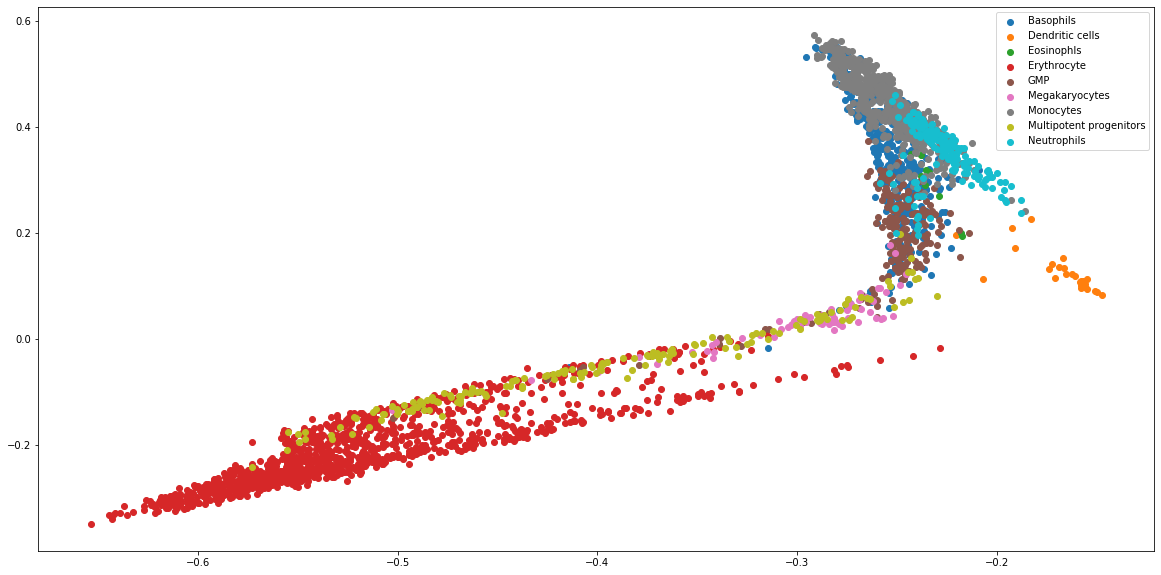

In [180]:
z = model(X, conn).detach().cpu().numpy()

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()

# data 3, oeHBC data, small one 
cluster_types = np.unique(clusters.values)
colormap = plt.cm.get_cmap("tab10", cluster_types.shape[0])
for i, cluster_type in enumerate(cluster_types):
    index = np.where(clusters.values == cluster_type)[0]
    ax.scatter(z[index,0], z[index,1], color = colormap(i), alpha = 1)

ax.legend(cluster_types)

In [101]:
from sklearn import datasets
n_points = 3000
testX, color = datasets.make_s_curve(n_points, random_state=0)

DPT_test = diff.DPT_similarity(testX)

In [102]:
test_G = graphtools.Graph(DPT_test, precomputed='distance', knn=10)
test_conn = test_G.K / np.linalg.norm(test_G.K)
test_conn = torch.FloatTensor(test_conn)

In [103]:
testX = torch.FloatTensor(testX)

In [104]:
test_model = gnn_ae(testX.shape[1], 256, 128, 128, 32, 2)
optimizer = optim.Adam(test_model.parameters(), lr=5e-2)
test_model.reset_parameters()
for epoch in range(0, 100):
    loss = train(test_model, testX, test_conn)
    if epoch % 10 == 0:
        print('epoch: ', epoch, ' loss: ', loss)

epoch:  0  loss:  2.083733221525108e-07
epoch:  10  loss:  2.0288113944388897e-07
epoch:  20  loss:  2.0287765778448374e-07
epoch:  30  loss:  2.028276071541768e-07
epoch:  40  loss:  2.0278157819575426e-07
epoch:  50  loss:  2.0280548085338523e-07
epoch:  60  loss:  2.028000380960293e-07
epoch:  70  loss:  2.0279513535115257e-07
epoch:  80  loss:  2.0279931334243884e-07
epoch:  90  loss:  2.0278980628063437e-07


&lt;matplotlib.collections.PathCollection at 0x14dd13acc08&gt;

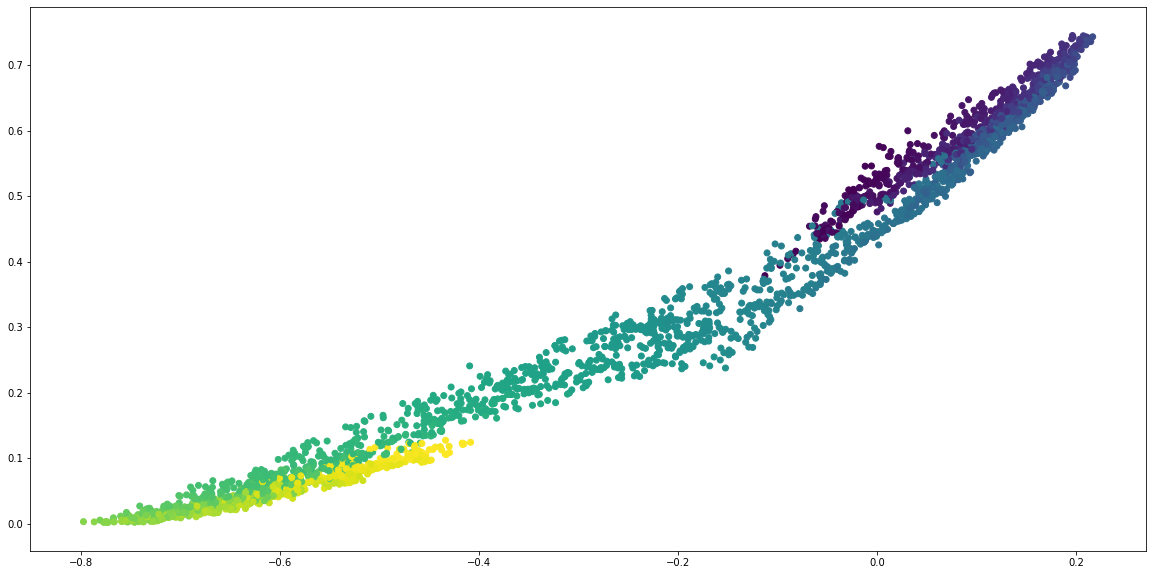

In [105]:
test_model.eval()
ae_coordinates = test_model(testX, test_conn).detach().numpy()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()

ax.scatter(ae_coordinates[:,0],ae_coordinates[:,1], c = color)